In [7]:
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import scipy
import scipy.stats as st 

In [8]:
category_order = ["ALDEx2-MEM", "QMP", "NBZIMM", "LinDA", "lmerSeq", "ANCOM-BC2"]

alcohol_free_base = pd.read_csv("../results/treatalcoholfree_mouthwash_timec15min_later.csv").reset_index(drop=True)
alcohol_free_base["genus"] = alcohol_free_base['genus'].str.strip('g_').str.replace("_", "")
alcohol_free_base['genus'] = alcohol_free_base['genus'].str.replace(r'\[.*?\]', '', regex=True)
alcohol_free_base['genus'] = alcohol_free_base['genus'].str.replace(r'\(.*?\)', '', regex=True)
alcohol_free = alcohol_free_base.loc[alcohol_free_base["method"]!="ALDEx2-MEM-TP"]
alcohol_free["method"] = pd.Categorical(alcohol_free["method"], categories=category_order, ordered=True)

In [9]:
alcohol_free = alcohol_free.sort_values(by="method").drop_duplicates(subset=["method", "genus"], keep="first")
genera = alcohol_free.loc[(alcohol_free["padj"] <= 0.05)]["genus"].tolist()
genera = sorted(list(set(genera)))
alcohol_free = alcohol_free.loc[alcohol_free["genus"].isin(genera)]
alcohol_free = alcohol_free.sort_values(by=["genus", "method"])

In [10]:
def assign_color(row):
    if row['padj'] > 0.05:
        return 'grey'  # Non-significant p-value
    elif row['est'] > 0:
        return 'blue'  # Significant and positive LFC
    else:
        return 'red'   # Significant and negative LFC 

     Unnamed: 0      method          genus       est      padj  sparsity  \
0           277  ALDEx2-MEM    Abiotrophia -7.276666  0.043896        31   
59          282         QMP    Abiotrophia -1.127788  0.532007        31   
236         281      NBZIMM    Abiotrophia -3.190999  0.005606        31   
118         278       LinDA    Abiotrophia -3.343774  0.275918        31   
177         279     lmerSeq    Abiotrophia -2.327332  0.137237        31   
..          ...         ...            ...       ...       ...       ...   
112         168         QMP  Streptococcus -4.507308  0.015377         0   
289         167      NBZIMM  Streptococcus  0.000000  1.000000         0   
171         164       LinDA  Streptococcus  0.764599  0.577310         0   
230         165     lmerSeq  Streptococcus -0.094514  0.917688         0   
348         166   ANCOM-BC2  Streptococcus -0.366719  0.875467         0   

     log2_mean color  
0            6   red  
59           6  grey  
236          6   r

/tmp/ipykernel_66659/2141476937.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_matrix = pivot_table.replace(color_map).fillna(0)


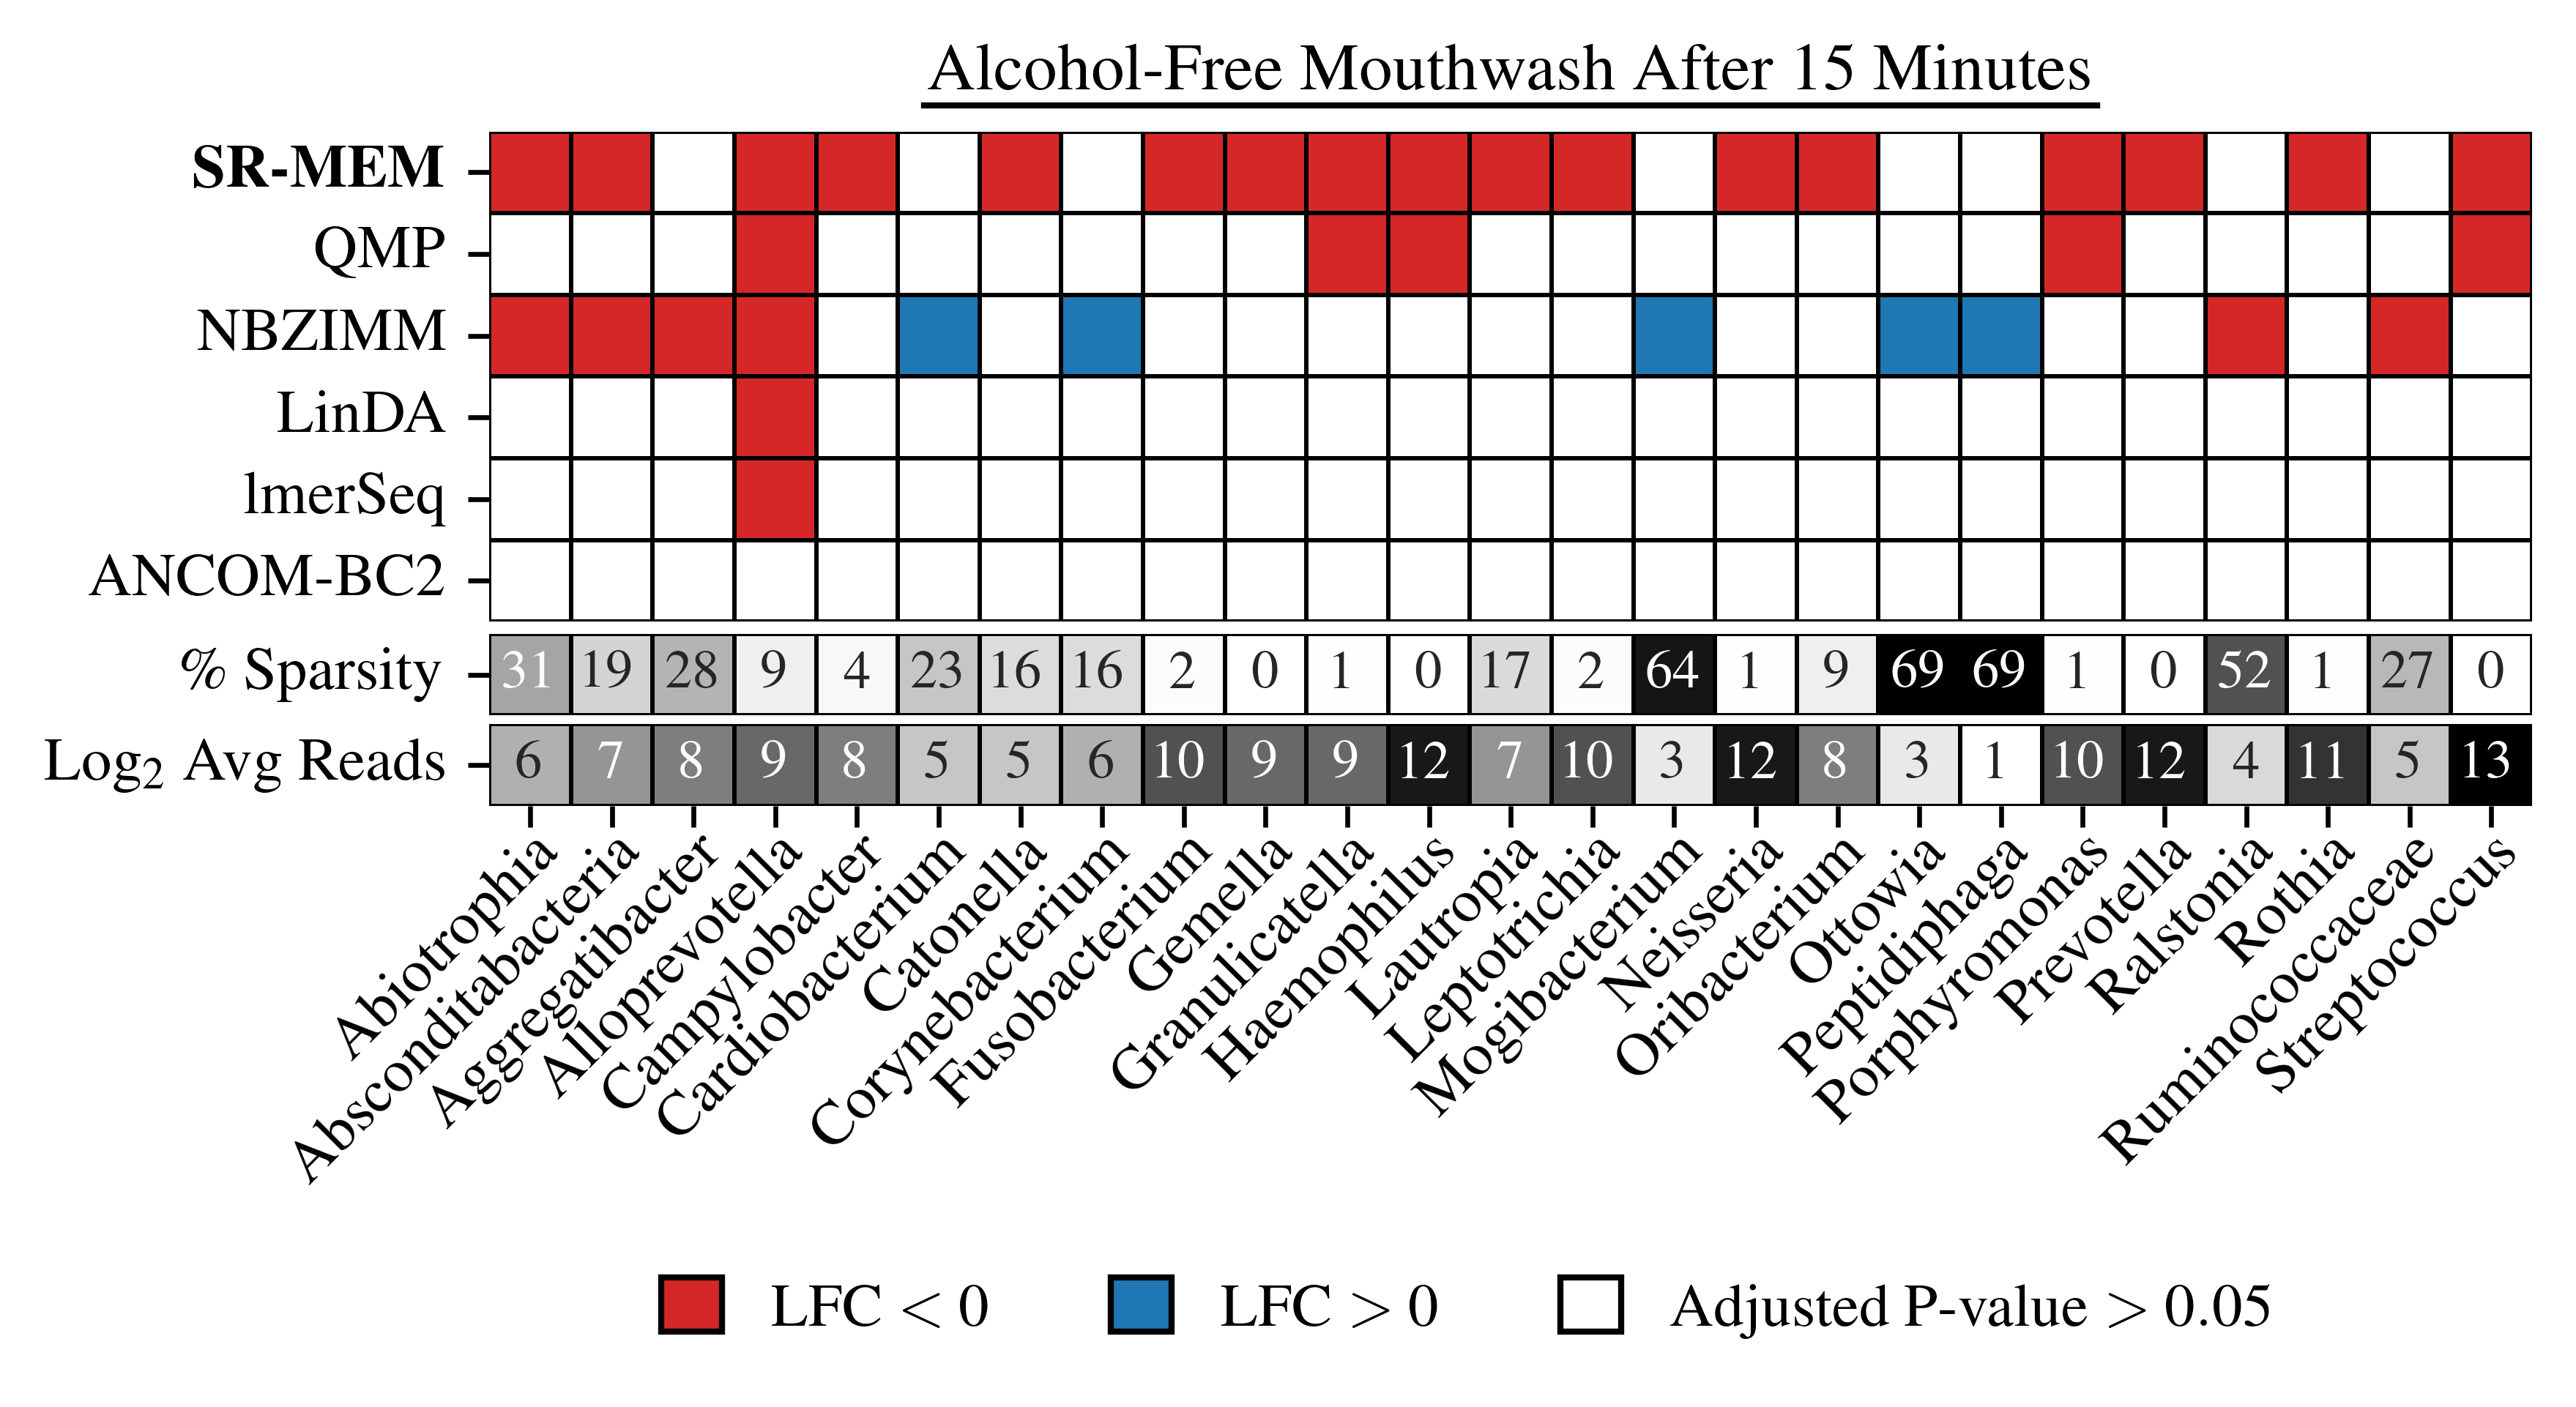

In [11]:
plt.rcParams["font.family"] = "Times"
plt.rcParams["text.usetex"] = True

width = 6
height = 4
dpi = 600
pw = width*dpi
ph = height*dpi
fontsize=11
color_map = {'grey': 0, 'blue': 1, 'red': -1}

fig = plt.figure(figsize=(pw/dpi, ph/dpi), dpi=dpi, constrained_layout=False)
subfigs = fig.subfigures(1, 1)
square=True
sparsity_color="Greys"
log2_colors="Greys"
hspace_a = -0.66
hspace_b = -0.825

### C ###

gs = gridspec.GridSpec(2, 1, height_ratios=[0.7, 0.3], hspace=hspace_a, figure=subfigs)
##gs0 = gridspec.GridSpecFromSubplotSpec(1, 1, height_ratios=[0.45, 0.55], subplot_spec=gs[0], hspace=0.4)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, height_ratios=[0.5, 0.5], hspace=hspace_b, subplot_spec=gs[1])
ax1 = subfigs.add_subplot(gs[0])
ax2 = subfigs.add_subplot(gs1[0])
ax3 = subfigs.add_subplot(gs1[1])

alcohol_free['color'] = alcohol_free.apply(assign_color, axis=1)
print(alcohol_free)
pivot_table = alcohol_free.pivot(columns='genus', index='method', values='color')
numeric_matrix = pivot_table.replace(color_map).fillna(0)
cmap = sns.color_palette(['#d62728', "white", '#1f77b4'], as_cmap=True)
sns.heatmap(
    data=numeric_matrix,
    annot=False, 
    yticklabels=True,
    xticklabels=False,
    cmap=cmap, cbar=False,
    linecolor="black",
    linewidths=0.5,
    ax=ax1, square=square)
yticklabels = ax1.get_yticklabels()
yticklabels[0] = "\\textbf{SR-MEM}"
##yticklabels[0].set_fontweight('bold')
ax1.set_yticklabels(yticklabels, fontsize=fontsize-1)
ax1.set_xlabel('')
ax1.set_ylabel('')
x = np.arange(numeric_matrix.shape[1]+1)
y = np.arange(numeric_matrix.shape[0]+1)
ax1.set_title("Alcohol-Free Mouthwash After 15 Minutes", fontsize=fontsize, loc="center", pad=7)

sparsity = alcohol_free.loc[alcohol_free["method"]=="ALDEx2-MEM", "sparsity"].to_frame().T
sparsity.columns = alcohol_free.loc[alcohol_free["method"]=="ALDEx2-MEM", "genus"]
sns.heatmap(
    data=sparsity,
    annot=True, fmt="", 
    yticklabels=True,
    xticklabels=False,
    cmap=sparsity_color, cbar=False,
    linecolor="black",
    linewidths=0.5,
    ax=ax2, square=square,
    annot_kws={'size': fontsize-2})
ax2.set_yticklabels(["\\% Sparsity"], rotation=0, fontsize=fontsize-1)
ax2.set_xlabel('')
ax2.set_ylabel('')

log2_mean = alcohol_free.loc[alcohol_free["method"]=="ALDEx2-MEM", "log2_mean"].to_frame().T
log2_mean.columns = alcohol_free.loc[alcohol_free["method"]=="ALDEx2-MEM", "genus"]
sns.heatmap(
    data=log2_mean,
    annot=True, fmt="", 
    yticklabels=True,
    xticklabels=True,
    cmap=log2_colors, cbar=False,
    linecolor="black",
    linewidths=0.5,
    ax=ax3, square=square,
    annot_kws={'size': fontsize-2})
ax3.set_yticklabels(["Log$_2$ Avg Reads"], rotation=0, fontsize=fontsize-1)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right', va='top',
                    fontsize=fontsize-1, rotation_mode="anchor")
ax3.tick_params(axis='x', which='major', pad=-0.5)
ax3.set_xlabel('')
ax3.set_ylabel('')

legend_elements = [Patch(facecolor='#d62728', edgecolor='black', label='LFC $< 0$'),
                   Patch(facecolor='#1f77b4', edgecolor='black', label='LFC $> 0$'),
                   Patch(facecolor='white',   edgecolor='black', label='Adjusted P-value $> 0.05$')]
ax3.legend(bbox_to_anchor=(0.9, -5.1), handles=legend_elements, frameon=False, ncol=3, fontsize=fontsize-1, handlelength=1, handleheight=1)
fig.add_artist(plt.Line2D([0.29, 0.735], [0.632, 0.632], color='black', linewidth=1))

In [12]:
fig.savefig('../../../figures/Figure_2.png', bbox_inches='tight')